# Set up

In [1]:
# update path with data dir
import sys
sys.path.append('../../optimiser/')

In [2]:
import pandas as pd
import patsy
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from mlens.ensemble import SuperLearner
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import optimiser
import scipy.stats
import itertools

[MLENS] backend: threading


# Getting data

In [3]:
file_name = '../csvs/element_gameweek_features_v06.csv'

In [4]:
element_gameweek_df = pd.read_csv(file_name)

In [5]:
element_gameweek_df.fillna(
    element_gameweek_df[element_gameweek_df['event'] <= 20].mean(),
    inplace=True
)

In [6]:
all_element_gameweek_df = element_gameweek_df.copy()

In [109]:
all_element_gameweek_df['predicted_total_points'] = 0

In [8]:
[i for i in list(element_gameweek_df.columns) if i not in [
     'safe_web_name',
     'element',
     'event',
     'fixture',
     'team',
     'opposition_team',
     'element_type',
     'minutes',
     'rolling_value_points',
     'total_points',
     
     'expected_total_points_against_opposition_team',
     'rolling_avg_total_points_element_home',
     'rolling_max_total_points_element',
     'rolling_avg_bps_element',
     'expected_total_points_element_home_away',
     'rolling_avg_total_points_element_away',
     'rolling_avg_total_points_own_team',
     'rolling_avg_total_points_against_opposition_team',
     'rolling_avg_minutes_element',
     'rolling_avg_total_points_opposition_team',
     'rolling_avg_dribbles_element',
     'rolling_avg_total_points_against_opposition_team_element_type',
     'rolling_avg_total_points_against_opposition_team_element_type_away',
     'rolling_avg_total_points_against_opposition_team_element_type_home',
     'rolling_avg_goals_conceded_element',
     'rolling_avg_completed_passes_element',
     'rolling_avg_total_points_element_type',
     'rolling_avg_recoveries_element',
]]

['was_home',
 'is_sunday',
 'is_weekday',
 'is_early',
 'is_late',
 'value',
 'rolling_avg_total_points_element',
 'has_high_points_ever_element',
 'rolling_avg_bonus_element',
 'rolling_avg_goals_scored_element',
 'rolling_avg_clean_sheets_element',
 'rolling_avg_assists_element',
 'rolling_avg_key_passes_element',
 'rolling_avg_winning_goals_element',
 'rolling_avg_tackled_element',
 'rolling_avg_clearances_blocks_interceptions_element',
 'rolling_avg_big_chances_created_element',
 'rolling_avg_target_missed_element',
 'rolling_avg_fouls_element',
 'rolling_avg_tackles_element',
 'rolling_avg_open_play_crosses_element',
 'rolling_avg_offside_element',
 'rolling_avg_big_chances_missed_element',
 'rolling_avg_saves_element',
 'rolling_avg_attempted_passes_element',
 'rolling_avg_errors_leading_to_goal_element',
 'rolling_avg_errors_leading_to_goal_attempt_element',
 'rolling_avg_own_goals_element',
 'rolling_avg_penalties_concededd_element',
 'rolling_avg_penalties_missed_element',
 'r

# Evaluating models

## Helpers

### Modelling

In [9]:
formula = \
'total_points ~ C(element_type) + C(team) + C(opposition_team) + ' + \
' + '.join([i for i in element_gameweek_df.columns if i not in
 [
     'safe_web_name',
     'element',
     'event',
     'fixture',
     'team',
     'opposition_team',
     'element_type',
     'minutes',
     'rolling_value_points',
     'total_points',
     
     'expected_total_points_against_opposition_team',
     'rolling_avg_total_points_element_home',
     'rolling_max_total_points_element',
     'rolling_avg_bps_element',
     'expected_total_points_element_home_away',
     'rolling_avg_total_points_element_away',
     'rolling_avg_total_points_own_team',
     'rolling_avg_total_points_against_opposition_team',
     'rolling_avg_minutes_element',
     'rolling_avg_total_points_opposition_team',
     'rolling_avg_dribbles_element',
     'rolling_avg_total_points_against_opposition_team_element_type',
     'rolling_avg_total_points_against_opposition_team_element_type_away',
     'rolling_avg_total_points_against_opposition_team_element_type_home',
     'rolling_avg_goals_conceded_element',
     'rolling_avg_completed_passes_element',
     'rolling_avg_total_points_element_type',
     'rolling_avg_recoveries_element',
 ]])

In [10]:
scaled_feature_cols = [
    i for i in element_gameweek_df.columns if i not in [
        'safe_web_name', 'element', 'event', 'fixture', 'team',
        'opposition_team', 'element_type', 'was_home', 'is_sunday',
        'is_weekday', 'is_late', 'is_early', 'has_high_points_ever_element',
        'total_points', 'minutes', 'rolling_value_points'
    ]
]

In [11]:
def calculate_expected_total_points_against_opposition_team_home_away(row):
    a = 'rolling_avg_total_points_against_opposition_team_element_type_home'
    b = 'rolling_avg_total_points_against_opposition_team_element_type_away'
    c = 'rolling_avg_total_points_element'
    d = 'rolling_avg_total_points_element_type'
    if row['was_home'] == 1:
        return row[a] * row[c] / row[d]
    else:
        return row[b] * row[c] / row[d]


def munge_data(df, e, prediction_events, minute_threshold=60):
    # filter weeks after test week
    event_df = df.copy()
    event_df = event_df[event_df['event'] <= e + prediction_events - 1]

    cols = event_df.columns

    # columns that we can fill down
    unknown_element_cols = [
        'was_home',
        'is_sunday',
        'is_weekday',
        'is_early',
        'is_late',
        'value',
        'rolling_avg_total_points_element',
        'has_high_points_ever_element',
        'rolling_avg_bonus_element',
        'rolling_avg_goals_scored_element',
        'rolling_avg_clean_sheets_element',
        'rolling_avg_assists_element',
        'rolling_avg_key_passes_element',
        'rolling_avg_winning_goals_element',
        'rolling_avg_tackled_element',
        'rolling_avg_clearances_blocks_interceptions_element',
        'rolling_avg_big_chances_created_element',
        'rolling_avg_target_missed_element',
        'rolling_avg_fouls_element',
        'rolling_avg_tackles_element',
        'rolling_avg_open_play_crosses_element',
        'rolling_avg_offside_element',
        'rolling_avg_big_chances_missed_element',
        'rolling_avg_saves_element',
        'rolling_avg_attempted_passes_element',
        'rolling_avg_errors_leading_to_goal_element',
        'rolling_avg_errors_leading_to_goal_attempt_element',
        'rolling_avg_own_goals_element',
        'rolling_avg_penalties_concededd_element',
        'rolling_avg_penalties_missed_element',
        'rolling_avg_penalties_saved_element',
        'rolling_avg_red_cards_element',
        'rolling_avg_yellow_cards_element',
        'rolling_avg_minutes_element_p3',
        'rolling_avg_total_points_element_p3',
        'rolling_avg_goals_scored_opposition_team',
        'rolling_avg_goals_conceded_opposition_team',
        'rolling_avg_total_points_element_type',
    ]

    # columns we need to look up
    unknown_opposition_cols = [
        'rolling_avg_goals_scored_opposition_team',
        'rolling_avg_goals_conceded_opposition_team',
        'rolling_avg_total_points_against_opposition_team_element_type_home',
        'rolling_avg_total_points_against_opposition_team_element_type_away',
    ]

    # columns we need to calculate
    unknown_engineered_cols = [
        'expected_total_points_against_opposition_team_home_away',
    ]

    # fill in nans for future data we wouldn't know
    event_df.loc[event_df['event'] > e,
                 unknown_element_cols + unknown_opposition_cols + unknown_engineered_cols
                ] = np.nan
    event_df.sort_values(['element', 'event', 'fixture'], inplace=True)
    # fill down the element data
    event_df[unknown_element_cols] = event_df[unknown_element_cols].fillna(method='ffill')

    # create look up tables for opposition team data
    # we have to look two events back, as some teams won't have played last event
    against_opposition_event_df_1 = event_df[event_df['event'] == e][
        ['opposition_team','element_type','event'] + unknown_opposition_cols].drop_duplicates()


    against_opposition_event_df_2 = event_df[event_df['event'] == e - 1][
        ['opposition_team','element_type','event'] + unknown_opposition_cols].drop_duplicates()

    against_opposition_event_df = pd.concat([against_opposition_event_df_1, against_opposition_event_df_2])

    # get the most recent opposition team data
    against_opposition_event_df = against_opposition_event_df.join(
        against_opposition_event_df.groupby(['opposition_team', 'element_type'])['event'].max(),
        on=['opposition_team', 'element_type'],
        rsuffix='_most_recent')

    against_opposition_event_df = \
    against_opposition_event_df[against_opposition_event_df['event'] == against_opposition_event_df['event_most_recent']]

    event_df = event_df.join(
        against_opposition_event_df.set_index(['opposition_team', 'element_type']),
        on=['opposition_team', 'element_type'],
        rsuffix='_fill')

    # fill in opposition team data from lookup table
    for i in unknown_opposition_cols:
        event_df.loc[event_df['event'] > e, i] = event_df[event_df['event'] > e][i+'_fill']

    event_df['expected_total_points_against_opposition_team_home_away'] = \
    event_df.apply(calculate_expected_total_points_against_opposition_team_home_away, axis=1)

    # filter for frequently appearing players
    event_df = event_df[event_df['rolling_avg_minutes_element_p3'] >= minute_threshold][cols]
    
    return event_df


def split_data(event_df, last_train_event, last_test_event):
    # define train-test split
    test_fold = [-1 if i <= last_train_event else 0 for i in event_df['event'] if i <= last_test_event]
    ps = PredefinedSplit(test_fold)

    # split df into train and test
    for train_index, test_index in ps.split():
        event_df_train, event_df_test = \
        event_df.copy().iloc[train_index], event_df.copy().iloc[test_index]
    
    return event_df_train, event_df_test, ps


def standardise_data(event_df, event_df_train, event_df_test, scaled_feature_cols):
    scale_train = event_df_train.copy()
    scale_test = event_df_test.copy()
    scale_df = event_df.copy()
    scaled_event_df_train = event_df_train.copy()
    scaled_event_df_test = event_df_test.copy()
    scaled_event_df = event_df.copy()

    scaler = StandardScaler().fit(scale_train[scaled_feature_cols].values)

    scale_train = scaler.transform(scale_train[scaled_feature_cols].values)
    scale_test = scaler.transform(scale_test[scaled_feature_cols].values)
    scale_df = scaler.transform(scale_df[scaled_feature_cols].values)

    scaled_event_df_train[scaled_feature_cols] = scale_train
    scaled_event_df_test[scaled_feature_cols] = scale_test
    scaled_event_df[scaled_feature_cols] = scale_df
    
    return scaled_event_df_train, scaled_event_df_test, scaled_event_df


def get_pcs(event_X_train, event_X_test, n_categorical_features):
    pca = PCA()
    pca.fit(event_X_train[:,(n_categorical_features + 1):])
    
    event_X_train_pca = np.concatenate(
        (
            event_X_train[:,:(n_categorical_features + 1)],
            pca.transform(event_X_train[:,(n_categorical_features + 1):])
        ), axis=1)
    
    event_X_test_pca = np.concatenate(
        (
            event_X_test[:,:(n_categorical_features + 1)],
            pca.transform(event_X_test[:,(n_categorical_features + 1):])
        ), axis=1)
    
    return event_X_train_pca, event_X_test_pca


def split_matrices(event_X, event_y, ps):
    for train_index, test_index in ps.split():
        event_X_train, event_X_test = event_X[train_index], event_X[test_index]
        event_y_train, event_y_test = event_y[train_index], event_y[test_index]
    
    return event_X_train, event_X_test, event_y_train, event_y_test


def select_features(event_X, event_X_train, event_X_test, features_index):    
    event_X_train_sel = event_X_train[:,features_index]
    event_X_test_sel = event_X_test[:,features_index]
    event_X_sel = event_X[:,features_index]
    
    return event_X_train_sel, event_X_test_sel, event_X_sel


def retune_model(event_df,
                 last_train_event,
                 last_validation_event,
                 standardise,
                 features_index,
                 model,
                 parameter_space,
                 n_iter_tune=100):
    
    # split data into train and validation set
    event_df_train, event_df_validation, ps_tune = split_data(event_df, last_train_event, last_validation_event)

    # standardise appropriate variables if necessary
    scaled_event_df = event_df.copy()
    if standardise:
        scaled_event_df_train, scaled_event_df_validation, scaled_event_df = \
        standardise_data(event_df, event_df_train, event_df_validation, scaled_feature_cols)        

    # get reponse vector and feature matrix
    event_y, event_X = patsy.dmatrices(formula, scaled_event_df, return_type='matrix')

    # split response vector and feature matrix into train and test
    event_X_train, event_X_validation, event_y_train, event_y_validation = \
    split_matrices(event_X, event_y, ps_tune)

    # if only certain features selected, get their indices
    event_X_train_sel = event_X_train
    event_X_validation_sel = event_X_validation
    event_X_sel = event_X
    if features_index:
        event_X_train_sel, event_X_validation_sel, event_X_sel = \
        select_features(event_X, event_X_train, event_X_validation, features_index)
    
    # search hyperparameter space
    tuner = RandomizedSearchCV(
        model,
        parameter_space,
        n_iter=n_iter_tune,
        scoring='neg_mean_squared_error',
        refit=True,
        cv=ps_tune,
        error_score=100, n_jobs=1)
    
    tuner.fit(event_X_sel, event_y.ravel())
    
    return tuner.best_estimator_

### Predicting points

In [124]:
def predict_test_set(df,
                     model,
                     parameter_space=False,
                     prediction_events=1,
                     prediction_weight=1,
                     features_index=False,
                     standardise=False,
                     pcs=False,
                     start=21,
                     end=38,
                     n_iter_tune=100,
                     verbose=0):
    y_pred_arr = []
    y_test_arr = []
    event_df_test_arr = []

    # for each event we want to predict
    for e in range(start, end + 1):
        if verbose > 0:
            print('predicting event', e)
        
        # munge data
        event_df = munge_data(df, e, prediction_events, minute_threshold=60)

        # split df into train and test
        event_df_train, event_df_test, ps = split_data(event_df, e - 1, 38)
        
        # standardise appropriate variables if necessary
        scaled_event_df = event_df.copy()
        if standardise:
            scaled_event_df_train, scaled_event_df_test, scaled_event_df = \
            standardise_data(event_df, event_df_train, event_df_test, scaled_feature_cols)        

        # get reponse vector and feature matrix
        event_y, event_X = patsy.dmatrices(formula, scaled_event_df, return_type='matrix')
        
        # split response vector and feature matrix into train and test
        event_X_train, event_X_test, event_y_train, event_y_test = \
        split_matrices(event_X, event_y, ps)
        
        # get pcs if necessary
        if pcs:
            n_categorical_features = event_X.design_info.column_names.index('value') - 1
            event_X_train, event_X_test = get_pcs(event_X_train, event_X_test, n_categorical_features)
        
        # if only certain features selected, get their indices
        event_X_train_sel = event_X_train
        event_X_test_sel = event_X_test
        event_X_sel = event_X
        if features_index:
            event_X_train_sel, event_X_test_sel, event_X_sel = \
            select_features(event_X, event_X_train, event_X_test, features_index)
            
        # retune hyperparameters
        if parameter_space:
            model = retune_model(event_df,
                                 e - 6,
                                 e - 1,
                                 standardise,
                                 features_index,
                                 model,
                                 parameter_space,
                                 n_iter_tune)

        # fit model on training data
        model.fit(event_X_train_sel, event_y_train.ravel())
        # predict test event
        event_y_pred = model.predict(event_X_test_sel).flatten()
        
        # collect predictions and observations 
        y_pred_arr.append(event_y_pred)
        y_test_arr.append(event_y_test)
        
        event_df_test['predicted_total_points'] = event_y_pred
        event_df_test['prediction_event'] = e
        
        event_df_test_arr.append(event_df_test)
        
    
    return np.concatenate(y_pred_arr).ravel(), np.concatenate(y_test_arr).ravel(), pd.concat(event_df_test_arr)

### Constructing teams

In [142]:
def get_event_players(
    df,
    e,
    prediction_events,
    optimise_key,
    prediction_weight):
    
    event_players = df.copy()
    
    event_players = \
    event_players[
        (event_players['prediction_event'] == e)
        & (event_players['event'] <= e + prediction_events - 1)
    ]        
    present_elements = event_players['element'].drop_duplicates().values
    all_df = all_element_gameweek_df.copy()
    all_df = all_df[all_df['event'] == e]
    all_df['prediction_event'] = e
    event_players = pd.concat([event_players, all_df[~all_df['element'].isin(present_elements)]])
    
    
    event_players['event_diff'] = event_players['event'] - event_players['prediction_event']
    event_players['prediction_weight'] = prediction_weight**(event_players['event_diff'])
    event_players['optimise_key_weighted'] = event_players['prediction_weight'] * event_players[optimise_key]
    
    event_players_df = event_players.copy()
    
    event_players_group = event_players.groupby('element')['optimise_key_weighted'].sum()
    event_players = event_players[['element', 'value', 'element_type', 'team']].drop_duplicates()
    event_players = event_players.join(event_players_group, on='element')
    event_players = event_players.to_dict('records')
    
    return event_players, event_players_df

In [143]:
def construct_event_teams_from_existing(df,
                                        prediction_events=1,
                                        prediction_weight=1,
                                        from_scratch_prediction_events=1,
                                        optimise_key='predicted_total_points',
                                        total_budget=1000,
                                        formation=[1, 5, 4, 1],
                                        start=21,
                                        end=38,
                                        transfer_penalty=4,
                                        transfer_limit=11,
                                        verbose=0):
    first_team_arr = []
    bench_arr = []
    team_total_points_arr = []
    predicted_team_total_points_arr = []
    team_df_arr = []
    transfers_arr = []
    carried_over_transfers = 0
    
    for e in range(start, end + 1):
        if verbose > 0:
            print('predicting event', e)
        
        event_players, event_players_df = get_event_players(
            df,
            e,
            prediction_events,
            optimise_key,
            prediction_weight
        )
        
        from_scratch_event_players, _ = get_event_players(
            df,
            e,
            from_scratch_prediction_events,
            optimise_key,
            prediction_weight
        )
        
        if e == start:
            try:
                event_first_team, event_bench = \
                optimiser.construct_optimal_team_from_scratch(
                    from_scratch_event_players,
                    optimise_key='optimise_key_weighted',
                    total_budget=total_budget,
                    formation=formation,
                )

                first_team_arr.append(event_first_team)
                bench_arr.append(event_bench)
                transfers_arr.append([set(), set()])
                
                event_num_transfers = 1
            except Exception as ex:
                print(e, ex)
                first_team_arr.append([])
                bench_arr.append([])
                transfers_arr.append([])
                
                event_num_transfers = 1
        else:
            try:
                event_first_team, event_bench, event_transfers = \
                optimiser.construct_optimal_team_from_existing(
                    event_players,
                    event_first_team,
                    event_bench,
                    total_budget=total_budget,
                    optimise_key='optimise_key_weighted',
                    transfer_penalty=transfer_penalty,
                    transfer_limit=transfer_limit
                )

                first_team_arr.append(event_first_team)
                bench_arr.append(event_bench)
                transfers_arr.append(event_transfers)
                
                event_num_transfers = len(event_transfers[0])
            except Exception as ex:
                print(e, ex)
                first_team_arr.append(event_first_team)
                bench_arr.append(event_bench)
                transfers_arr.append([set(), set()])
                
                event_num_transfers = 0
        
        event_num_transfers = max(event_num_transfers - carried_over_transfers, 0)
        
        event_team_total_points, event_team_predicted_total_points, event_team_df = \
        optimiser.calculate_team_total_points(event_players_df,
                                              event_first_team,
                                              event_bench,
                                              e,
                                              event_num_transfers,
                                              carried_over_transfers)
        
        if event_num_transfers == 0 and carried_over_transfers == 0:
            carried_over_transfers = 1
        if event_num_transfers in (0, 1) and carried_over_transfers == 1:
            carried_over_transfers = 1
        if event_num_transfers == 1 and carried_over_transfers == 0:
            carried_over_transfers = 0
        if event_num_transfers > 1:
            carried_over_transfers = 0


        team_total_points_arr.append(event_team_total_points)
        predicted_team_total_points_arr.append(event_team_predicted_total_points)
        team_df_arr.append(event_team_df)
    
    return (
        first_team_arr, bench_arr,
        team_total_points_arr,
        predicted_team_total_points_arr,
        team_df_arr,
        transfers_arr
    )

## Constructing teams

### Linear regression

In [251]:
lr_model = LinearRegression()

In [252]:
lr_features_index = [
    False, True, True, True, True, False, False, False, True, True, True, True,
    True, False, True, False, True, False, True, True, False, False, True,
    True, True, True, True, False, True, True, True, True, True, True, True,
    True, True, True, False, True, True, True, True, False, True, True, True,
    True, False, False, False, False, False, False, True, True, False, False,
    False, False, False, False, False, False, True, False, False, False, False,
    False, True, False, False, False, False, True, True, True, False, False
]

In [253]:
lr_y_pred, lr_y_test, lr_df_test = predict_test_set(
    element_gameweek_df,
    lr_model,
    standardise=True,
    features_index=lr_features_index,
    pcs=False,
    prediction_events=5,
    verbose=True
)

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


In [254]:
lr_test_loss = (
    mean_absolute_error(lr_y_test, lr_y_pred),
    mean_squared_error(lr_y_test, lr_y_pred),
    r2_score(lr_y_test, lr_y_pred)
)
lr_test_loss

(2.265125529240642, 9.468913426516353, 0.08453958030942732)

In [ ]:
(
    lr_first_team_arr,
    lr_bench_arr,
    lr_total_points_arr,
    lr_predicted_total_points_arr,
    lr_team_df_arr,
    lr_transfers_arr
) = \
construct_event_teams_from_existing(
    lr_df_test,
    total_budget=1057.75,
    prediction_events=2,
    from_scratch_prediction_events=5,
    transfer_penalty=4,
    transfer_limit=1,
    verbose=1)
    

lr_total_points = sum(lr_total_points_arr)
lr_mean_transfers = np.mean([len(lr_transfers_arr[i][0]) for i in range(0, len(lr_transfers_arr))])
lr_total_points, lr_mean_transfers

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


(1129, 0.6666666666666666)

### Ridge regression

In [ ]:
ridge_model = Ridge(alpha=1e-8)

In [ ]:
ridge_features_index = [
    False, False, False, False, False, False, False, False, False, False,
    False, False, False, False, True, False, False, False, False, False, False,
    False, False, False, False, False, False, False, False, False, True, False,
    False, True, False, False, False, False, False, False, False, False, False,
    False, False, False, False, True, False, False, False, False, False, False,
    True, False, False, False, False, False, False, False, False, False, True,
    True, False, False, False, False, False, False, False, False, False, True,
    False, True, False, True
]

In [ ]:
ridge_y_pred, ridge_y_test, ridge_df_test = predict_test_set(
    element_gameweek_df,
    ridge_model,
    standardise=True,
    features_index=ridge_features_index,
    pcs=False,
    prediction_events=5,
    verbose=1
)

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


In [ ]:
ridge_test_loss = (
    mean_absolute_error(ridge_y_test, ridge_y_pred),
    mean_squared_error(ridge_y_test, ridge_y_pred),
    r2_score(ridge_y_test, ridge_y_pred)
)
ridge_test_loss

(2.2679697601623054, 9.464234821869661, 0.08499191070685519)

In [ ]:
(
    ridge_first_team_arr,
    ridge_bench_arr,
    ridge_total_points_arr,
    ridge_predicted_total_points_arr,
    ridge_team_df_arr,
    ridge_transfers_arr
) = \
construct_event_teams_from_existing(
    ridge_df_test,
    total_budget=1057.75,
    prediction_events=2,
    from_scratch_prediction_events=5,
    transfer_penalty=4,
    transfer_limit=1,
    verbose=1)
    

ridge_total_points = sum(ridge_total_points_arr)
ridge_mean_transfers = np.mean([len(ridge_transfers_arr[i][0]) for i in range(0, len(ridge_transfers_arr))])
ridge_total_points, ridge_mean_transfers

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


(1112, 0.6111111111111112)

### Lasso regression

In [300]:
lasso_model = Lasso(alpha=1e-8)

In [301]:
lasso_features_index = [
    False, False, False, False, False, False, False, False, False, False,
    False, False, False, False, True, False, False, False, False, False, False,
    False, False, False, False, False, False, False, False, False, False,
    False, False, False, False, False, False, False, False, False, False,
    False, True, False, False, False, True, True, False, False, False, False,
    False, False, True, False, False, False, False, False, False, False, False,
    False, True, True, False, False, False, False, True, False, False, False,
    False, True, False, True, True, True
]

In [302]:
lasso_y_pred, lasso_y_test, lasso_df_test = predict_test_set(
    element_gameweek_df,
    lasso_model,
    standardise=True,
    features_index=lasso_features_index,
    pcs=False,
    prediction_events=5,
    verbose=1
)

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


In [303]:
lasso_test_loss = (
    mean_absolute_error(lasso_y_test, lasso_y_pred),
    mean_squared_error(lasso_y_test, lasso_y_pred),
    r2_score(lasso_y_test, lasso_y_pred)
)
lasso_test_loss

(2.2605667877691764, 9.482650526051131, 0.08321146901101562)

In [304]:
(
    lasso_first_team_arr,
    lasso_bench_arr,
    lasso_total_points_arr,
    lasso_predicted_total_points_arr,
    lasso_team_df_arr,
    lasso_transfers_arr
) = \
construct_event_teams_from_existing(
    lasso_df_test,
    total_budget=1057.75,
    prediction_events=2,
    from_scratch_prediction_events=5,
    transfer_penalty=4,
    transfer_limit=1,
    verbose=1)
    

lasso_total_points = sum(lasso_total_points_arr)
lasso_mean_transfers = np.mean([len(lasso_transfers_arr[i][0]) for i in range(0, len(lasso_transfers_arr))])
lasso_total_points, lasso_mean_transfers

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


(1125, 0.6111111111111112)

In [324]:
lasso_team_df_arr[-3]

,safe_web_name,element,value,element_type,is_first_team,predicted_total_points,total_points,minutes,is_captain
9611,salah,253,132.0,3,1,7.996418,19,90,1
10257,sterling,270,116.0,3,1,5.314661,3,90,0
4633,hazard,122,109.0,3,1,5.247076,2,90,0
9383,robertson,247,68.0,2,1,5.133026,14,90,0
9345,van dijk,246,67.0,2,1,4.902785,6,90,0
8889,vardy,234,90.0,4,1,4.735149,13,90,0
6533,sigurdsson,172,73.0,3,1,4.092944,3,85,0
1783,ryan,47,44.0,1,1,3.251628,2,90,0
10067,walker,265,64.0,2,1,3.215908,9,90,0
8395,pereira,221,54.0,2,1,3.010089,10,90,0


In [325]:
lasso_team_df_arr[4]

,safe_web_name,element,value,element_type,is_first_team,predicted_total_points,total_points,minutes,is_captain
10246,sterling,270,113.0,3,1,10.626064,11,121,1
6522,sigurdsson,172,74.0,3,1,7.984225,3,117,0
9600,salah,253,136.0,3,1,7.709729,2,90,0
5838,pickford,154,50.0,1,1,6.283390,2,180,0
4622,hazard,122,109.0,3,1,6.173447,15,76,0
10170,laporte,268,59.0,2,1,5.359794,20,180,0
18378,digne,484,53.0,2,1,4.477540,1,90,0
9372,robertson,247,68.0,2,1,4.332469,2,90,0
11576,rashford,305,77.0,4,1,4.186205,7,77,0
9334,van dijk,246,65.0,2,1,4.090575,2,90,0


In [328]:
lasso_team_df_arr[-4]

,safe_web_name,element,value,element_type,is_first_team,predicted_total_points,total_points,minutes,is_captain
10255,sterling,270,116.0,3,1,9.526272,8,180,1
9610,salah,253,132.0,3,1,7.482906,6,90,0
4632,hazard,122,110.0,3,1,5.732879,7,90,0
10065,walker,265,64.0,2,1,5.608374,13,180,0
1781,ryan,47,44.0,1,1,5.170463,12,180,0
8888,vardy,234,90.0,4,1,4.617714,9,90,0
9382,robertson,247,68.0,2,1,4.419747,6,90,0
9344,van dijk,246,66.0,2,1,4.167194,7,90,0
6532,sigurdsson,172,73.0,3,1,4.040919,14,90,0
8394,pereira,221,54.0,2,1,2.997219,1,90,0


In [330]:
(
    lasso_free_hit_first_team_arr,
    lasso_free_hit_bench_arr,
    lasso_free_hit_total_points_arr,
    lasso_free_hit_predicted_total_points_arr,
    lasso_free_hit_team_df_arr,
    lasso_free_hit_transfers_arr
) = \
construct_event_teams_from_existing(
    lasso_df_test,
    total_budget=1057.75,
    prediction_events=1,
    from_scratch_prediction_events=1,
    transfer_penalty=4,
    transfer_limit=1,
    start=32,
    end=32,
    verbose=1)
    

lasso_free_hit_total_points = sum(lasso_free_hit_total_points_arr)
lasso_free_hit_mean_transfers = np.mean([len(lasso_free_hit_transfers_arr[i][0]) for i in range(0, len(lasso_free_hit_transfers_arr))])
lasso_free_hit_total_points, lasso_free_hit_mean_transfers

predicting event 32


(88, 0.0)

In [332]:
lasso_total_points_arr[]

[39, 80, 68, 22, 82, 61, 23, 80, 48, 70, 31, 91, 69, 58, 91, 107, 55, 50]

### Principal component regression

In [305]:
pc_model = LinearRegression()

In [306]:
pc_features_index = [
    False, False, True, False, False, False, False, False, False, False, False,
    False, False, False, True, False, False, False, False, False, False, False,
    False, False, False, False, False, False, False, False, True, False, False,
    True, False, False, False, False, False, False, False, False, True, False,
    False, False, True, True, True, True, True, True, True, False, False,
    False, True, True, False, False, True, True, True, True, True, False, True,
    False, False, False, False, False, True, False, True, True, True, False,
    False, False
]

In [307]:
pc_y_pred, pc_y_test, pc_df_test = predict_test_set(
    element_gameweek_df,
    pc_model,
    standardise=True,
    features_index=pc_features_index,
    pcs=True,
    prediction_events=5,
    verbose=1
)

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


In [308]:
pc_test_loss = (
    mean_absolute_error(pc_y_test, pc_y_pred),
    mean_squared_error(pc_y_test, pc_y_pred),
    r2_score(pc_y_test, pc_y_pred)
)
pc_test_loss

(2.2647519353487184, 9.445057070015855, 0.0868460276440366)

In [309]:
(
    pc_first_team_arr,
    pc_bench_arr,
    pc_total_points_arr,
    pc_predicted_total_points_arr,
    pc_team_df_arr,
    pc_transfers_arr
) = \
construct_event_teams_from_existing(
    pc_df_test,
    total_budget=1057.75,
    prediction_events=2,
    from_scratch_prediction_events=5,
    transfer_penalty=4,
    transfer_limit=1,
    verbose=1)
    

pc_total_points = sum(pc_total_points_arr)
pc_mean_transfers = np.mean([len(pc_transfers_arr[i][0]) for i in range(0, len(pc_transfers_arr))])
pc_total_points, pc_mean_transfers

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


(1102, 0.6666666666666666)

### Linear kernel

In [271]:
linear_model = SVR(kernel='linear', epsilon=1.92, C=3.05)

In [272]:
linear_features_index = [
    False, False, False, False, False, False, False, False, False, False,
    False, False, False, False, True, False, False, False, False, False, False,
    False, False, False, False, False, False, False, False, False, True, False,
    False, True, False, False, False, False, False, False, False, False, False,
    False, False, False, False, True, False, False, False, False, False, False,
    True, False, False, False, False, False, False, False, False, False, True,
    True, False, False, False, False, False, False, False, False, False, True,
    False, True, False, True
]

In [273]:
linear_y_pred, linear_y_test, linear_df_test = predict_test_set(
    element_gameweek_df,
    linear_model,
    features_index=linear_features_index,
    standardise=True,
    prediction_events=5,
    verbose=1
)

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


In [274]:
linear_test_loss = (
    mean_absolute_error(linear_y_test, linear_y_pred),
    mean_squared_error(linear_y_test, linear_y_pred),
    r2_score(linear_y_test, linear_y_pred)
)
linear_test_loss

(2.261715598333615, 9.53169709491669, 0.07846961632997718)

In [275]:
(
    linear_first_team_arr,
    linear_bench_arr,
    linear_total_points_arr,
    linear_predicted_total_points_arr,
    linear_team_df_arr,
    linear_transfers_arr
) = \
construct_event_teams_from_existing(
    linear_df_test,
    total_budget=1057.75,
    prediction_events=2,
    from_scratch_prediction_events=5,
    transfer_penalty=4,
    transfer_limit=1,
    verbose=1)
    

linear_total_points = sum(linear_total_points_arr)
linear_mean_transfers = np.mean([len(linear_transfers_arr[i][0]) for i in range(0, len(linear_transfers_arr))])
linear_total_points, linear_mean_transfers

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


(1097, 0.7777777777777778)

### RBF kernel

In [276]:
rbf_model = SVR(kernel='rbf', epsilon=1.95, C=100, gamma=0.00103)

In [277]:
rbf_features_index = [
    False, False, False, False, False, False, False, False, False, False,
    False, False, False, False, True, False, False, False, False, False, False,
    False, False, False, False, False, False, False, False, False, True, False,
    False, True, False, False, False, False, False, False, False, False, False,
    False, False, False, False, True, False, False, False, False, False, False,
    True, False, False, False, False, False, False, False, False, False, True,
    True, False, False, False, False, False, False, False, False, False, True,
    False, True, False, True
]

In [278]:
rbf_y_pred, rbf_y_test, rbf_df_test = predict_test_set(
    element_gameweek_df,
    rbf_model,
    features_index=rbf_features_index,
    standardise=True,
    prediction_events=5,
    verbose=1
)

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


In [279]:
rbf_test_loss = (
    mean_absolute_error(rbf_y_test, rbf_y_pred),
    mean_squared_error(rbf_y_test, rbf_y_pred),
    r2_score(rbf_y_test, rbf_y_pred)
)
rbf_test_loss

(2.2704447861435475, 9.488336732109499, 0.08266172308451225)

In [280]:
(
    rbf_first_team_arr,
    rbf_bench_arr,
    rbf_total_points_arr,
    rbf_predicted_total_points_arr,
    rbf_team_df_arr,
    rbf_transfers_arr
) = \
construct_event_teams_from_existing(
    rbf_df_test,
    total_budget=1057.75,
    prediction_events=2,
    from_scratch_prediction_events=5,
    transfer_penalty=4,
    transfer_limit=1,
    verbose=1)
    

rbf_total_points = sum(rbf_total_points_arr)
rbf_mean_transfers = np.mean([len(rbf_transfers_arr[i][0]) for i in range(0, len(rbf_transfers_arr))])
rbf_total_points, rbf_mean_transfers

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


(1075, 0.6111111111111112)

### Decision tree

In [281]:
tree_model = DecisionTreeRegressor(min_samples_leaf=0.0193)

In [282]:
tree_y_pred, tree_y_test, tree_df_test = predict_test_set(
    element_gameweek_df,
    tree_model,
    standardise=False,
    prediction_events=5,
    verbose=1
)

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


In [283]:
tree_test_loss = (
    mean_absolute_error(tree_y_test, tree_y_pred),
    mean_squared_error(tree_y_test, tree_y_pred),
    r2_score(tree_y_test, tree_y_pred)
)
tree_test_loss

(2.316577818782962, 9.873203390069293, 0.04545257602080266)

In [284]:
(
    tree_first_team_arr,
    tree_bench_arr,
    tree_total_points_arr,
    tree_predicted_total_points_arr,
    tree_team_df_arr,
    tree_transfers_arr
) = \
construct_event_teams_from_existing(
    tree_df_test,
    total_budget=1057.75,
    prediction_events=2,
    from_scratch_prediction_events=5,
    transfer_penalty=4,
    transfer_limit=1,
    verbose=1)
    

tree_total_points = sum(tree_total_points_arr)
tree_mean_transfers = np.mean([len(tree_transfers_arr[i][0]) for i in range(0, len(tree_transfers_arr))])
tree_total_points, tree_mean_transfers

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


(1051, 0.8888888888888888)

### Random forest

In [333]:
forest_teams_total_points_arr = []

for i in range(0, 100):
    print('iteration ', i)
    forest_model = RandomForestRegressor(
        criterion='mse',
        n_estimators=500,
        min_samples_leaf=0.0156,
        max_features=0.9)
    
    forest_y_pred, forest_y_test, forest_df_test = predict_test_set(
    element_gameweek_df,
    forest_model,
    standardise=False,
    prediction_events=5,
    verbose=0)
    
    (
        forest_first_team_arr,
        forest_bench_arr,
        forest_total_points_arr,
        forest_predicted_total_points_arr,
        forest_team_df_arr,
        forest_transfers_arr
    ) = \
    construct_event_teams_from_existing(
        forest_df_test,
        total_budget=1057.5,
        prediction_events=2,
        from_scratch_prediction_events=5,
        transfer_penalty=4,
        transfer_limit=1,
        verbose=0)
    
    forest_teams_total_points = sum(forest_total_points_arr)
    forest_teams_total_points_arr.append(forest_teams_total_points)

iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
iteration  10
iteration  11
iteration  12
iteration  13
iteration  14
iteration  15
iteration  16
iteration  17
iteration  18
iteration  20
iteration  21
iteration  22
iteration  23
iteration  24
iteration  25
iteration  26
iteration  27
iteration  28
iteration  29
iteration  30
iteration  31
iteration  32
iteration  33
iteration  34
iteration  35
iteration  36
iteration  37
iteration  38
iteration  39
iteration  40
iteration  41
iteration  42
iteration  43
iteration  45
iteration  46
iteration  47
iteration  48
iteration  49
iteration  50
iteration  51
iteration  52
iteration  53
iteration  54
iteration  55
iteration  56
iteration  57
iteration  58
iteration  59
iteration  60
iteration  61
iteration  62
iteration  63
iteration  64
iteration  65
iteration  66
iteration  67
iteration  68
iteration  69
iteration  70
iteration  71
iteration  72
iteration  73
it

(1074.31, 20.968879321508815)

In [344]:
forest_teams_total_points_mean = np.mean(forest_teams_total_points_arr) 
forest_teams_total_points_std = np.std(forest_teams_total_points_arr)
    
forest_teams_total_points_mean, forest_teams_total_points_std

(1074.31, 20.968879321508815)

### Gradient boosted trees

In [334]:
boost_teams_total_points_arr = []

for i in range(0, 100):
    print('iteration ', i)
    boost_model = GradientBoostingRegressor(
        criterion='mse',
        min_samples_leaf=0.0175,
        max_features=1.0,
        learning_rate=0.02,
        subsample=0.3,
        n_estimators=200
    )
    
    boost_y_pred, boost_y_test, boost_df_test = predict_test_set(
    element_gameweek_df,
    boost_model,
    standardise=False,
    prediction_events=5,
    verbose=0)
    
    (
        boost_first_team_arr,
        boost_bench_arr,
        boost_total_points_arr,
        boost_predicted_total_points_arr,
        boost_team_df_arr,
        boost_transfers_arr
    ) = \
    construct_event_teams_from_existing(
        boost_df_test,
        total_budget=1057.5,
        prediction_events=2,
        from_scratch_prediction_events=5,
        transfer_penalty=4,
        transfer_limit=1,
        verbose=0)
    
    boost_teams_total_points = sum(boost_total_points_arr)
    boost_teams_total_points_arr.append(boost_teams_total_points)

iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
iteration  10
iteration  11
iteration  12
iteration  13
iteration  14
iteration  15
iteration  16
iteration  17
iteration  18
iteration  19
iteration  20
iteration  21
iteration  22
iteration  23
iteration  24
iteration  25
iteration  26
iteration  27
iteration  28
iteration  29
iteration  30
iteration  31
iteration  32
iteration  33
iteration  34
iteration  35
iteration  36
iteration  37
iteration  38
iteration  39
iteration  40
iteration  41
iteration  42
iteration  43
iteration  44
iteration  45
iteration  46
iteration  47
iteration  48
iteration  49
iteration  50
iteration  51
iteration  52
iteration  53
iteration  54
iteration  55
iteration  56
iteration  57
iteration  58
iteration  59
iteration  60
iteration  61
iteration  62
iteration  63
iteration  64
iteration  65
iteration  66
iteration  67
iteration  68
iteration  69
iteration  70
iteration  71
it

(1062.81, 26.575061617990652)

In [339]:
boost_teams_total_points_mean = np.mean(boost_teams_total_points_arr) 
boost_teams_total_points_std = np.std(boost_teams_total_points_arr)
    
boost_teams_total_points_mean, boost_teams_total_points_std

(1062.81, 26.575061617990652)

### Random team benchmark

In [293]:
random_benchmark_df_test = lr_df_test.copy()

In [337]:
random_benchmark_teams_total_points_arr = []

for i in range(0, 100):
    random_benchmark_df_test['predicted_total_points'] = \
    np.random.random(len(lr_df_test['predicted_total_points'])) * 7
    
    (
        random_benchmark_first_team_arr,
        random_benchmark_bench_arr,
        random_benchmark_total_points_arr,
        random_benchmark_predicted_total_points_arr,
        random_benchmark_team_df_arr,
        random_benchmark_transfers_arr
    ) = \
    construct_event_teams_from_existing(
        random_benchmark_df_test,
        total_budget=1057.5,
        prediction_events=2,
        from_scratch_prediction_events=5,
        transfer_penalty=4,
        transfer_limit=1,
        verbose=1)
    
    random_benchmark_teams_total_points = sum(random_benchmark_total_points_arr)
    random_benchmark_teams_total_points_arr.append(random_benchmark_teams_total_points)

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38
predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38
predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34


predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38
predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
31 'NoneType' object is not iterable
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38
predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
pre

predicting event 36
predicting event 37
predicting event 38
predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
27 'NoneType' object is not iterable
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38
predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38
predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
pre

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
31 'NoneType' object is not iterable
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38
predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38
predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
pre

predicting event 35
predicting event 36
predicting event 37
predicting event 38
predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
31 'NoneType' object is not iterable
predicting event 32
predicting event 33
33 'NoneType' object is not iterable
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38
predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
31 'NoneType' object is not iterable
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38
predicting event 21
predicting event 22
predicting event 23
predicting event 24
predictin

(703.28, 68.65946111061461)

In [340]:
random_benchmark_teams_total_points_mean = np.mean(random_benchmark_teams_total_points_arr) 
random_benchmark_teams_total_points_std = np.std(random_benchmark_teams_total_points_arr)
    
random_benchmark_teams_total_points_mean, random_benchmark_teams_total_points_std

(703.28, 68.65946111061461)

# Summary

In [343]:
pd.DataFrame([
    ('Linear regression', lr_total_points),
    ('Ridge regression', ridge_total_points),
    ('Lasso regression', lasso_total_points),
    ('Principal component regression', pc_total_points),
    ('Linear kernel', linear_total_points),
    ('RBF kernel', rbf_total_points),
    ('Decision tree', tree_total_points),
    ('Random forest', forest_teams_total_points_mean),
    ('Gradient boosted trees', boost_teams_total_points_mean),
    ('Random team benchmark', random_benchmark_teams_total_points_mean),
], columns=['model', 'teams total points']).round(1)

,model,teams total points
0,Linear regression,1129.0
1,Ridge regression,1112.0
2,Lasso regression,1125.0
3,Principal component regression,1102.0
4,Linear kernel,1097.0
5,RBF kernel,1075.0
6,Decision tree,1051.0
7,Random forest,1074.3
8,Gradient boosted trees,1062.8
9,Random team benchmark,703.3


# Analysis

In [352]:
points = [
    1129,
    1112,
    1125,
    1102,
    1097,
    1075,
    1051,
    1074,
    1063,
]

errors = [
    9.389,
    9.411,
    9.351,
    9.382,
    9.483,
    9.444,
    9.742,
    9.412,
    9.418,
]

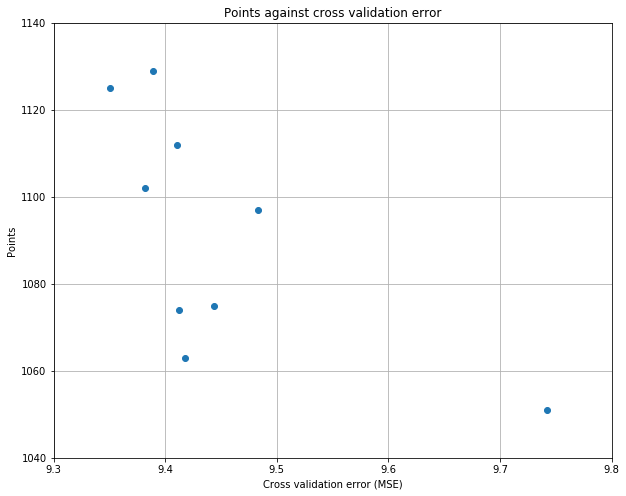

In [356]:
plt.figure(figsize=(10,8))
plt.scatter(errors, points)
plt.xlim(9.3, 9.8)
plt.ylim(1040, 1140)
plt.xlabel('Cross validation error (MSE)')
plt.ylabel('Points')
plt.grid()
plt.title('Points against cross validation error')
plt.show()